In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import bambi
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale

In [204]:
#Get adult data 
data = pd.read_csv("./Data/Howell1.csv", sep = ';')
data = data[data['age'] > 18]
data['male'] = pd.Categorical(data['male'])
height = scale(data['height'])
weight = scale(data['weight'])
data['male']

0      1
1      0
2      0
3      1
4      0
      ..
534    0
537    0
540    1
541    0
543    1
Name: male, Length: 346, dtype: category
Categories (2, int64): [0, 1]

In [3]:
with pm.Model() as model:
    height_data = pm.ConstantData('height_data',height,dims = 'obs_id')
    weight_data = pm.ConstantData('weight_data',weight,dims = 'obs_id')
    b     = pm.Uniform('b',0,1)
    a     = pm.Normal('a',0,10)
    sigma = pm.Uniform('sigma',0,10)
    
    mu = pm.Deterministic('mu', a + b*height_data,dims = 'obs_id')
    
    likelihood_W = pm.Normal('likelihood_W',mu,sigma,observed=weight_data,dims='obs_id')
    
    sample = pm.sample(tune=2000)

G:\Statistical_Rethinking\rethinking\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: 

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


array([<AxesSubplot: title={'center': 'a'}>,
       <AxesSubplot: title={'center': 'b'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

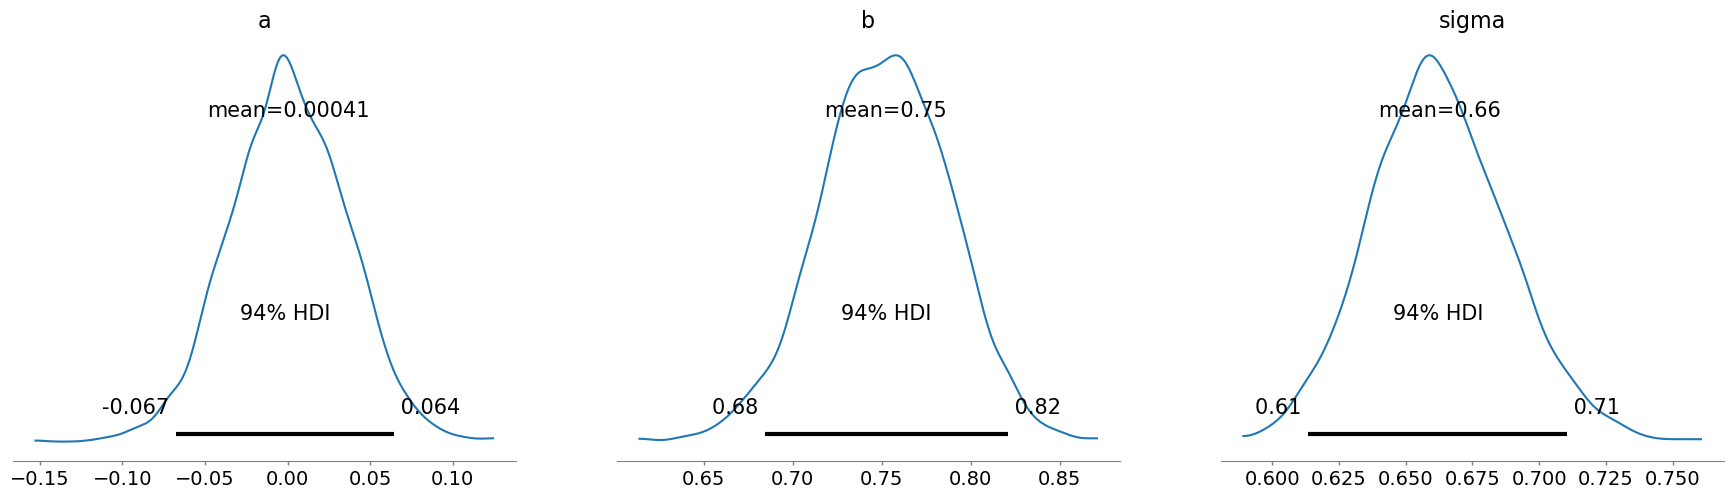

In [4]:
az.plot_posterior(sample, var_names=['a','b','sigma'])

In [5]:
#Simulating lines from prior
with model:
    sample.extend(pm.sample_prior_predictive(samples=100))

Sampling: [a, b, likelihood_W, sigma]


Text(0.5, 1.0, 'Prior predictive checks -- Flat priors')

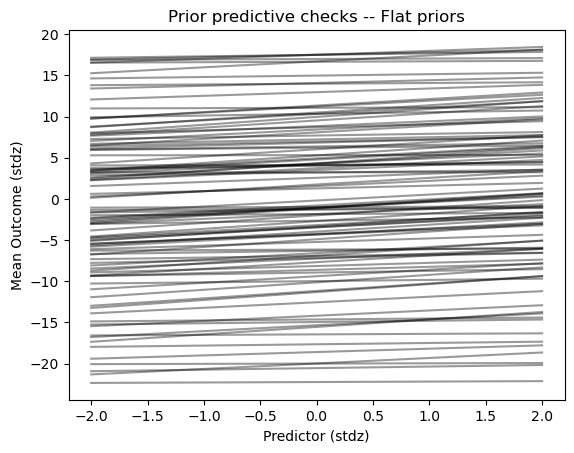

In [6]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
y = sample['prior']["a"] + sample['prior']["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors")

In [7]:
# Has reasonable slopes, but pretty unreasonable intercepts. 

In [8]:
#Simulation based Validation
#Simulation based calibration? 
sim_H = np.random.normal(0,5,1000)
U     = np.random.normal(0,5,len(sim_H))
b     = 0.2
sim_W = b*sim_H + U
sim_W[:10]

array([ 0.56796538, -0.95527646,  4.26662389, 10.42899148,  5.15689027,
       -0.75730758, 10.2825194 , -4.35518953, -6.03360724, -4.04187303])

In [9]:
with pm.Model() as sim_model:
    height_data = pm.ConstantData('height_data',sim_H,dims = 'obs_id')
    weight_data = pm.ConstantData('weight_data',sim_W,dims = 'obs_id')
    b     = pm.Uniform('b',0,1)
    a     = pm.Normal('a',0,10)
    sigma = pm.Uniform('sigma',0,10)
    
    mu = pm.Deterministic('mu', a + b*height_data,dims = 'obs_id')
    
    likelihood_W = pm.Normal('likelihood_W',mu,sigma,observed=weight_data,dims='obs_id')
    
    sim_sample = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


array([<AxesSubplot: title={'center': 'a'}>,
       <AxesSubplot: title={'center': 'b'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

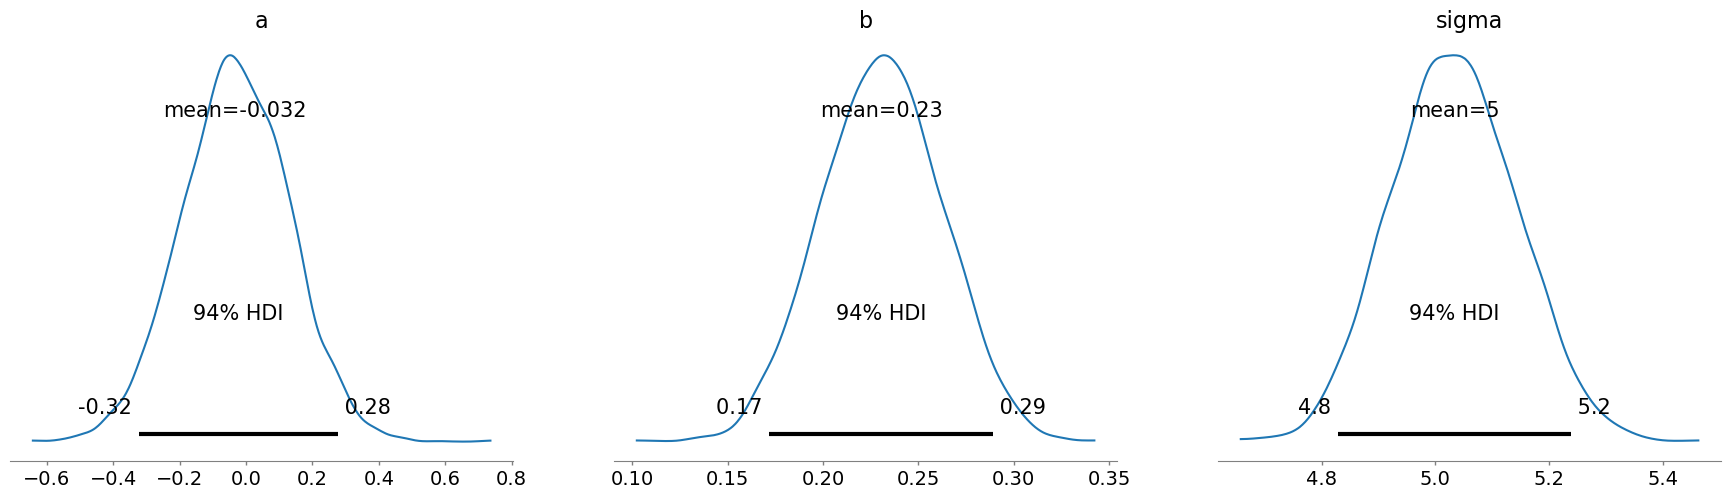

In [10]:
az.plot_posterior(sim_sample, var_names=['a','b','sigma'])

array([<AxesSubplot: title={'center': 'a'}>,
       <AxesSubplot: title={'center': 'b'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

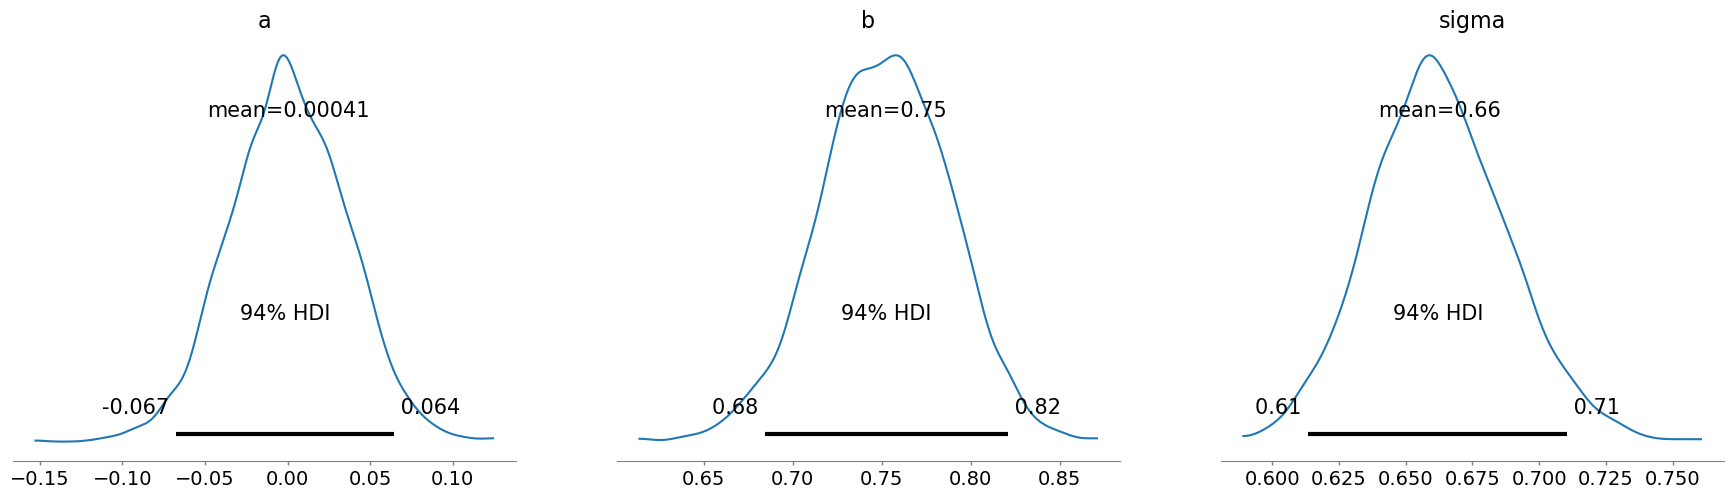

In [11]:
az.plot_posterior(sample, var_names=['a','b','sigma'])

In [12]:
with model:
    pm.sample_posterior_predictive(sample,extend_inferencedata = True)

Sampling: [likelihood_W]


In [13]:
sample['posterior_predictive']

<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000, obs_id: 346)
Coordinates:
  * chain         (chain) int32 0 1 2 3
  * draw          (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_id        (obs_id) int32 0 1 2 3 4 5 6 7 ... 339 340 341 342 343 344 345
Data variables:
    likelihood_W  (chain, draw, obs_id) float64 0.6148 -0.9254 ... 0.9168
Attributes:
    created_at:                 2023-01-12T05:39:34.213614
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.1

<AxesSubplot: xlabel='likelihood_W / likelihood_W'>

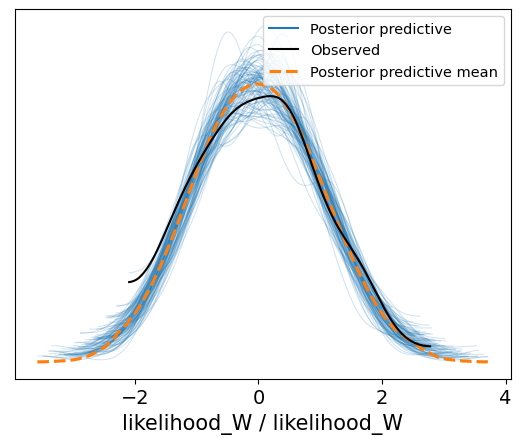

In [14]:
az.plot_ppc(sample, num_pp_samples=100)

In [15]:
mu_pp = sample.posterior['a'] +sample.posterior['b']*xr.DataArray(height, dims =['obs_id'])

Text(0, 0.5, 'Outcome (H) (stdz)')

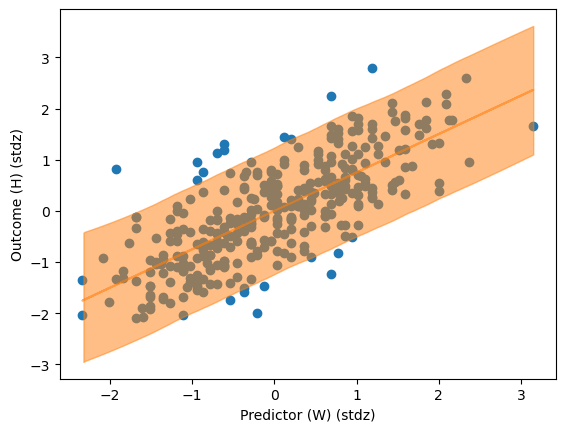

In [16]:
_, ax = plt.subplots()

ax.plot(
    height, mu_pp.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(height, sample.observed_data["likelihood_W"])
az.plot_hdi(height, sample.posterior_predictive["likelihood_W"])

ax.set_xlabel("Predictor (W) (stdz)")
ax.set_ylabel("Outcome (H) (stdz)")

## Lecture 4 Content

Generative model + multiple estimands = multiple estimators

Processing results, only very simple causal estimaates show up
summary tables

Categories & Curves
    - Linear models can do extra-linear things
    Categories (indicator & index variables)
    Splines and other additive structures 
Categories:
    - Cause that are not continuous
    Categories: Discrete, unordered types
    - Want to **stratify** by catefory: fit sepearate line for each
    
Using the Howel example: How are height/weight/sex causally
related?

H = f(S,U) # U is unobserved
W = F(H,S, V) # V is unobserved

The unobserved causes are ignorable unless they are shared!

In [165]:
#Generative model
N = 50 #N women and N men
H_W = 150 + np.random.normal(0,5,N)
H_M = 160 + np.random.normal(0,5,N)
W_W = 0 + 0.5*H_W + np.random.normal(0,5,N)
W_M = 0 + 0.6*H_M + np.random.normal(0,5,N)
women_d = {'S':np.zeros(N).astype(int),
          'H': H_W,
          'W':W_W}
men_d = {'S':np.ones(N).astype(int),
        'H': H_M,
        'W': W_M}

sexsim_d = pd.concat([pd.DataFrame(x) for x in [women_d,men_d]], ignore_index=True)

#Women = 0, Men = 1 
sexsim_d

,S,H,W
0,0,155.425875,78.433953
1,0,152.051792,75.882073
2,0,146.201874,72.573404
3,0,162.928160,79.389068
4,0,147.752459,73.739520
...,...,...,...
95,1,170.067715,102.867859
96,1,148.654720,82.144266
97,1,159.855427,96.701283
98,1,160.623259,98.240877


In [166]:
#Effect of sex in sim
np.mean(men_d['W'] - women_d['W'])

21.22654261835251

In [167]:
sexsim_d['S'] = pd.Categorical(sexsim_d['S'])
sexsim_d['S'].cat.categories.size

2

## Model Simulation 
Going to use index variables for sex

In [168]:
with pm.Model() as sex_sim:
    sigma = pm.Uniform('sigma',0,10)
    a = pm.Normal('a',60,10,shape = sexsim_d['S'].cat.categories.size)
    #b = pm.Normal('b',0,1,shape = sexsim_d['S'].cat.categories.size)
    #u = pm.Normal('u',0,5)
#    mu = a[np.array(sexsim_d['S']).astype(int)]
    mu = a[sexsim_d['S']]# + b[sexsim_d['S']]*sexsim_d['H'] + u
    
    W = pm.Normal('W',mu,sigma, observed = sexsim_d['W'])
    sex_sim_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


array([<AxesSubplot: title={'center': 'a\n0'}>,
       <AxesSubplot: title={'center': 'a\n1'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

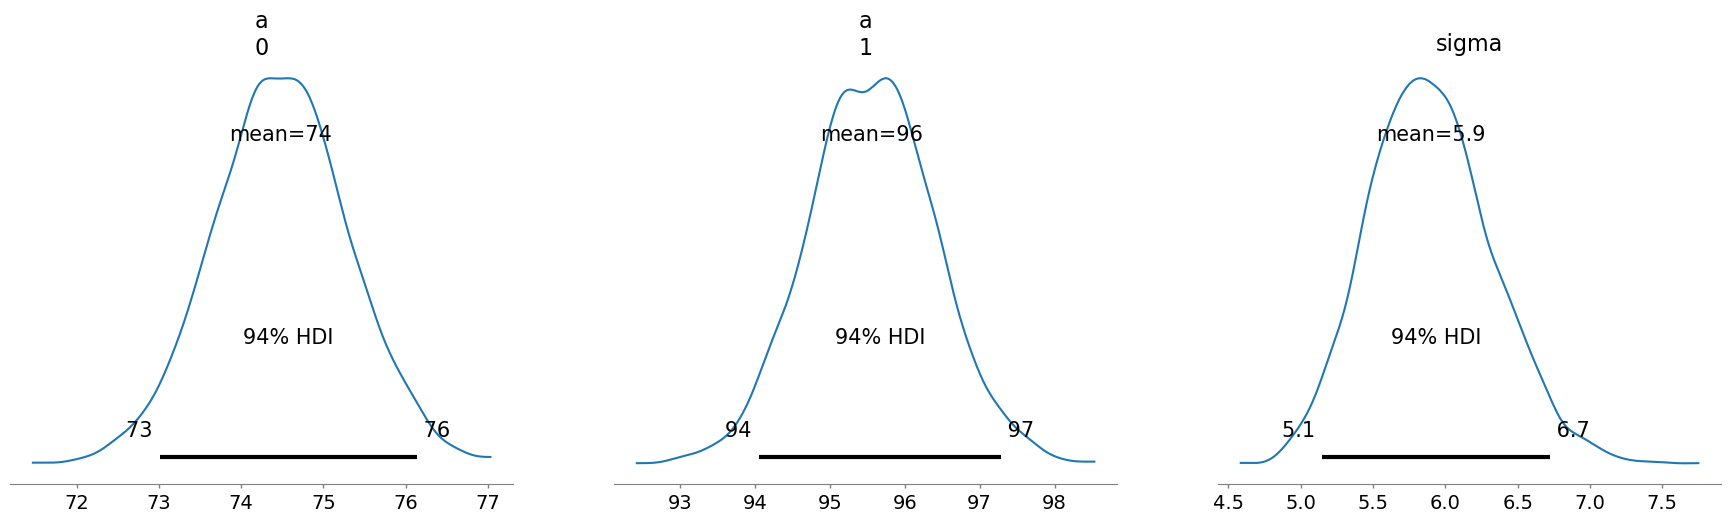

In [169]:
az.plot_posterior(sex_sim_trace)

In [170]:
type(np.array(sexsim_d['S'])[0])

numpy.int64

In [171]:
(sex_sim_trace['posterior']['a'][:,:,0] - sex_sim_trace['posterior']['a'][:,:,1])

<xarray.DataArray 'a' (chain: 4, draw: 1000)>
array([[-21.45832038, -22.42055493, -20.16183582, ..., -21.37001929,
        -21.51649654, -21.2008726 ],
       [-21.84356295, -20.13246027, -22.30008189, ..., -21.5773564 ,
        -20.67686856, -19.56267329],
       [-20.28814387, -20.28814387, -23.08920274, ..., -21.37954461,
        -23.35087786, -18.18047743],
       [-19.32403728, -19.41519832, -22.4033485 , ..., -20.76211856,
        -23.63330448, -20.31707672]])
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

<AxesSubplot: title={'center': 'a'}>

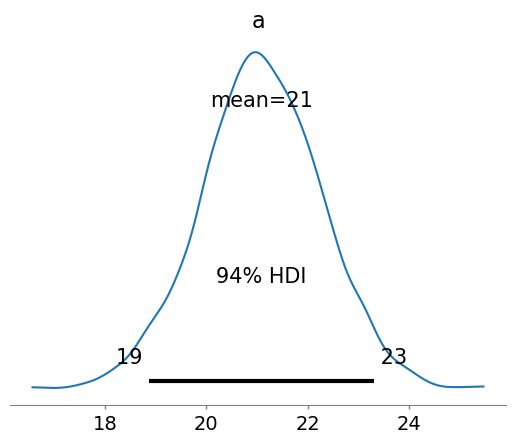

In [172]:
#Computing the contrast by takign the difference between the two variables. This is the estimand
#This is the posterior distribution of differences
#OUr knowledge of average difference. 
az.plot_posterior((sex_sim_trace['posterior']['a'][:,:,1] - sex_sim_trace['posterior']['a'][:,:,0]))

In [176]:
with sex_sim:
    sex_sim_trace.extend(pm.sample_posterior_predictive(sex_sim_trace))

Sampling: [W]


array([<AxesSubplot: title={'center': 'a\n0'}>,
       <AxesSubplot: title={'center': 'a\n1'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

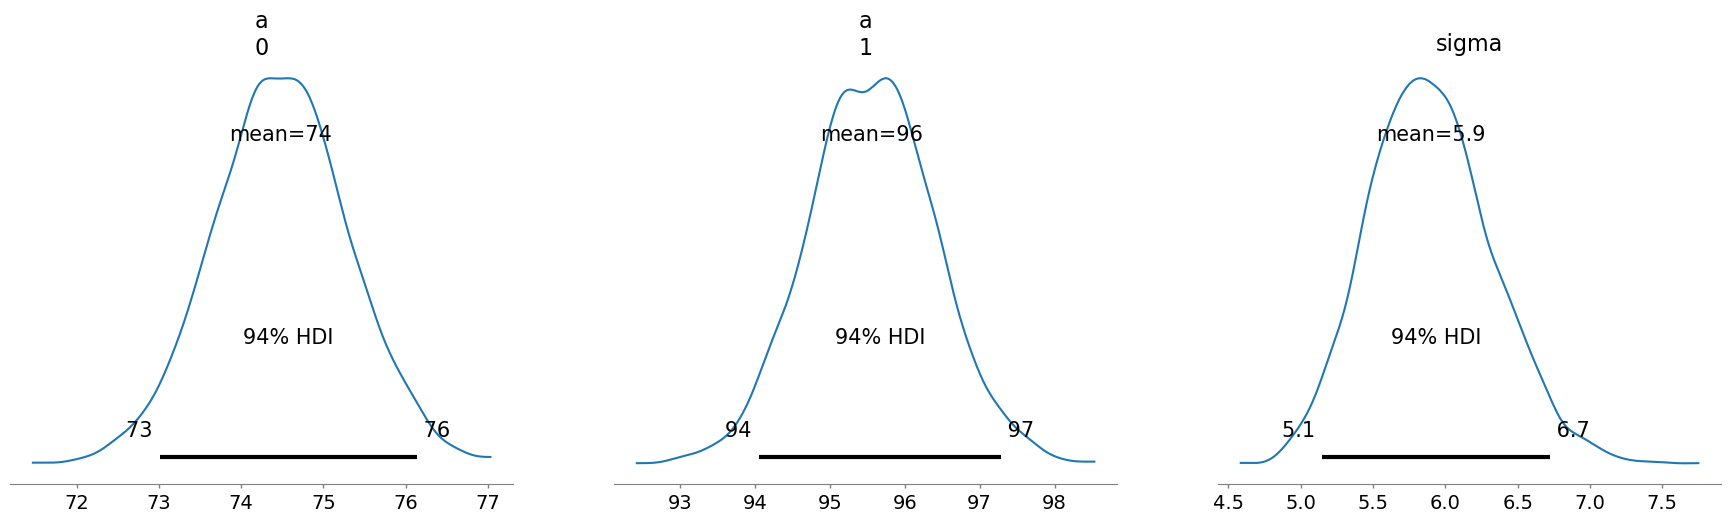

In [177]:
az.plot_posterior(sex_sim_trace)

<AxesSubplot: xlabel='W / W'>

G:\Statistical_Rethinking\rethinking\Lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
G:\Statistical_Rethinking\rethinking\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


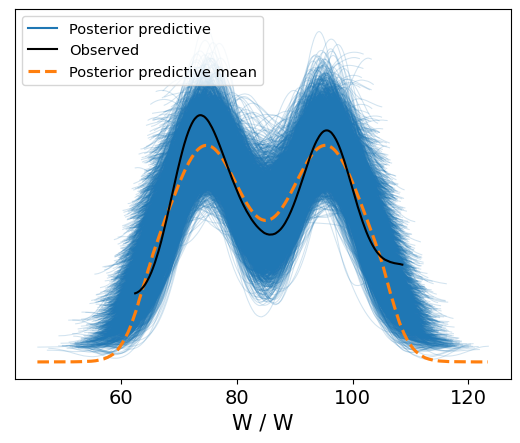

In [179]:
#np.random.normal(sex_sim_trace['posterior']['a'][:,:,1],sex_sim_trace['posterior']['sigma'],1)
az.plot_ppc(sex_sim_trace)

In [180]:
sex_sim_trace['posterior_predictive']['W'].shape

(4, 1000, 100)

In [189]:
sex_sim_mean = az.summary(sex_sim_trace)['mean']
sex_sim_mean

a[0]     74.477
a[1]     95.560
sigma     5.896
Name: mean, dtype: float64

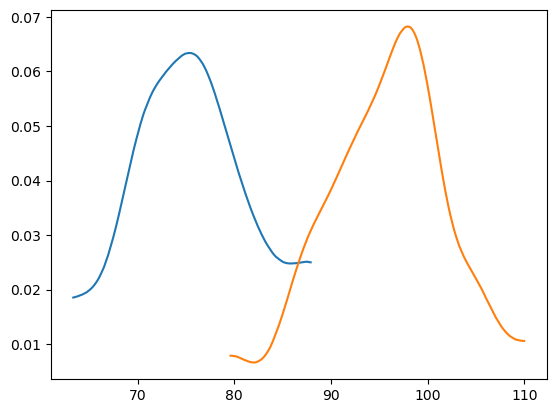

In [197]:
w_test = np.random.normal(sex_sim_mean['a[0]'],sex_sim_mean['sigma'],50)
m_test = np.random.normal(sex_sim_mean['a[1]'],sex_sim_mean['sigma'],50)
gridw, pdfw = az.kde(w_test)
gridm, pdfm = az.kde(m_test)
plt.plot(gridw, pdfw)
plt.plot(gridm, pdfm)


<AxesSubplot: >

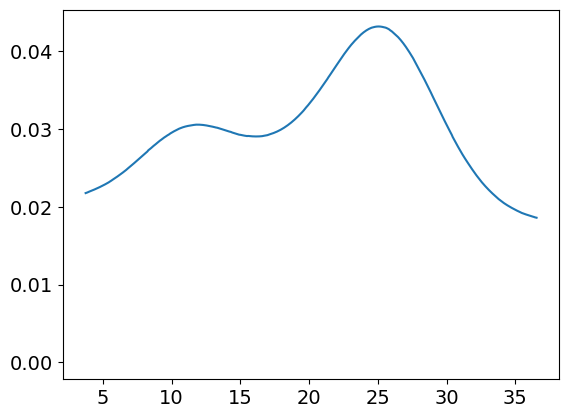

In [198]:
#plotting test contrast
contrast_test = m_test - w_test
az.plot_kde(contrast_test)

## Actual Data 

In [210]:
## Using actual data
with pm.Model() as sex_model:
    sigma = pm.Uniform('sigma',0,10)
    a = pm.Normal('a',60,10,shape = data['male'].cat.categories.size)
    #b = pm.Normal('b',0,1,shape = sexsim_d['S'].cat.categories.size)
    #u = pm.Normal('u',0,5)
#    mu = a[np.array(sexsim_d['S']).astype(int)]
    mu = a[data['male']]# + b[sexsim_d['S']]*sexsim_d['H'] + u
    
    W = pm.Normal('W',mu,sigma, observed = data['weight'])
    sex_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


array([<AxesSubplot: title={'center': 'a\n0'}>,
       <AxesSubplot: title={'center': 'a\n1'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

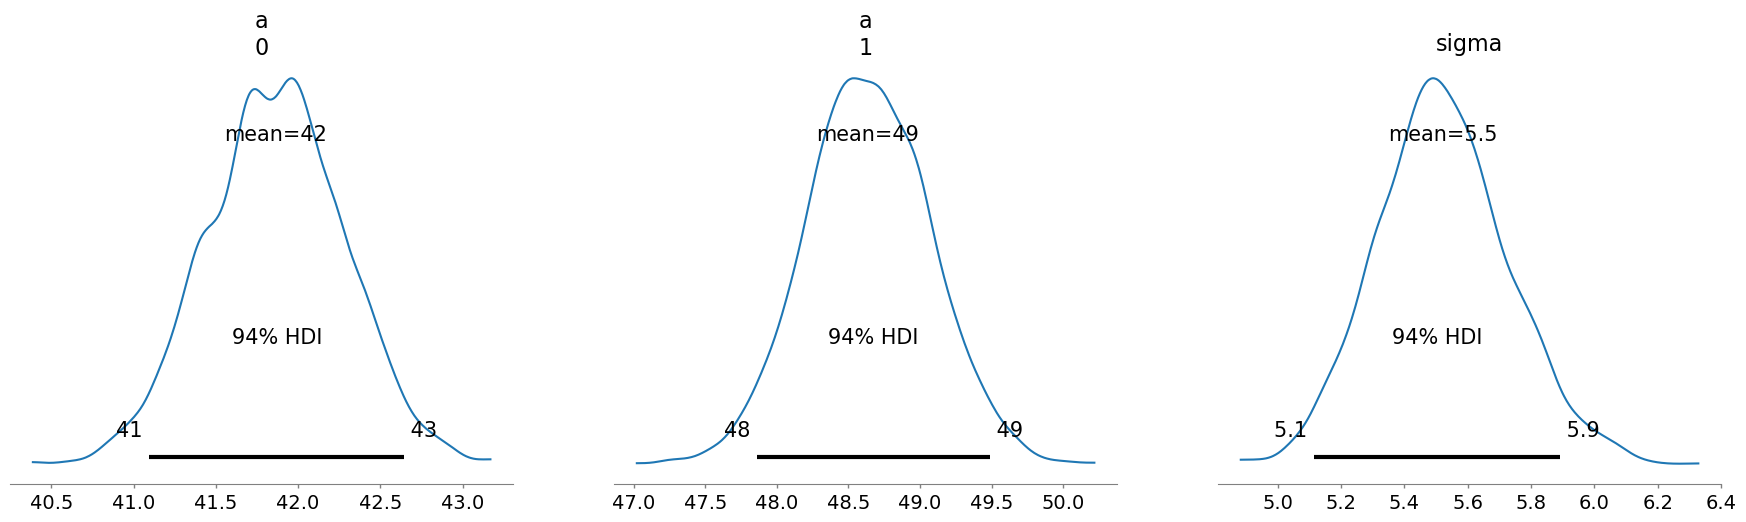

In [211]:
az.plot_posterior(sex_trace)

In [215]:
sex_mean = az.summary(sex_trace)['mean']
sex_mean

a[0]     41.864
a[1]     48.636
sigma     5.520
Name: mean, dtype: float64

## Our Answer/Estimand
The following graphs provide answers to our estimand, the causal effect of S on W. The two contrasts give answer as to their mean and the whole weight distributions. 

Causal effect because it lets you address the question of 'what happens to a persons weight, if we were to change their sex' it is a **distribution** and that is the estimate (points are not estimates, they are decisions).  

<AxesSubplot: title={'center': 'a'}>

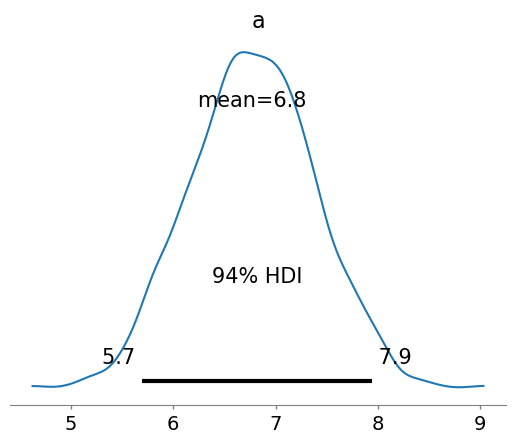

In [212]:
az.plot_posterior((sex_trace['posterior']['a'][:,:,1] - sex_trace['posterior']['a'][:,:,0]))

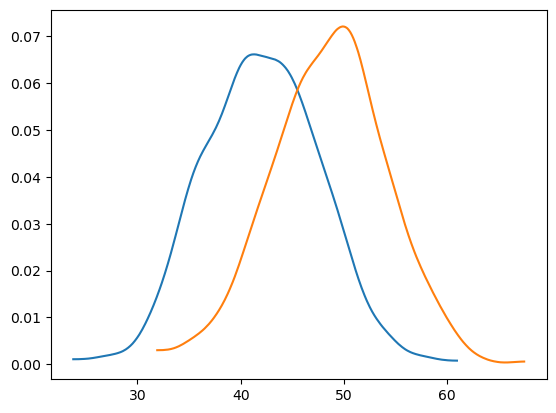

In [222]:
w = np.random.normal(sex_mean['a[0]'],sex_mean['sigma'],1000)
m = np.random.normal(sex_mean['a[1]'],sex_mean['sigma'],1000)
gridw, pdfw = az.kde(w)
gridm, pdfm = az.kde(m)
plt.plot(gridw, pdfw)
plt.plot(gridm, pdfm)

<AxesSubplot: >

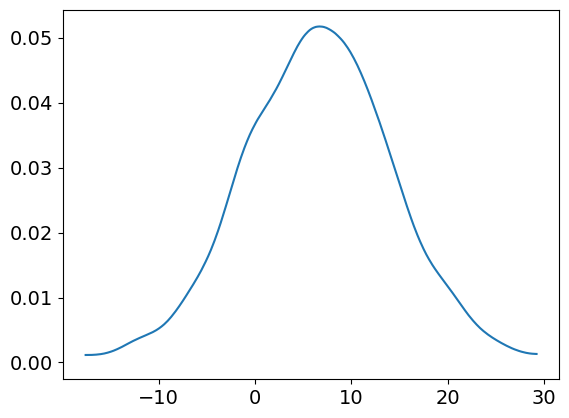

In [223]:
az.plot_kde(m-w) 

In [234]:
contrast = m-w
len(contrast[contrast >= 0])/1000

0.802

## Direct Causal Effect of S on W

Need to stratify by Height 
Need to center height by removing Hbar (average height)

**Cool Fact**
A linear regression line will always pass through the average point (xbar,ybar)

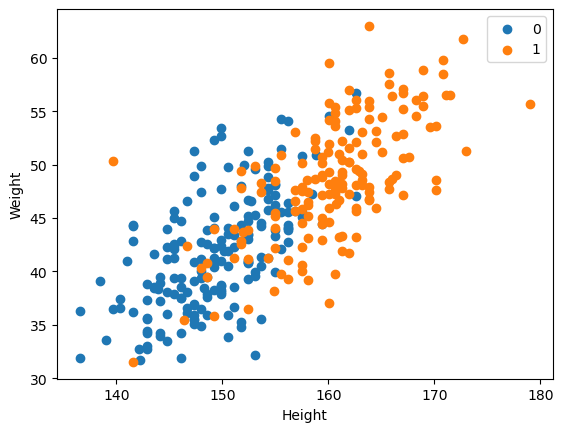

In [245]:
grouped = data.groupby('male')
for name,group in grouped:
    plt.scatter(group['height'],group['weight'],label=name)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.legend()

In [258]:
with pm.Model() as dsex_model:
    sigma = pm.Exponential('sigma',1)
    a     = pm.Normal('a',45,10, shape = data['male'].cat.categories.size)
    b     = pm.Normal('b', 0, 5, shape = data['male'].cat.categories.size)
    
    mu    = a[data['male']] + b[data['male']]*(data['height']-data['height'].mean()) #Need to center (hbar), a becomes expected weight when h is expected (average)
    W     = pm.Normal('W',mu,sigma,observed = data['weight'])
    dsex_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [259]:
az.summary(dsex_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],45.153,0.447,44.314,45.972,0.008,0.006,2857.0,2954.0,1.0
a[1],45.107,0.455,44.289,46.009,0.008,0.006,3144.0,2526.0,1.0
b[0],0.644,0.062,0.527,0.758,0.001,0.001,2763.0,2592.0,1.0
b[1],0.614,0.055,0.508,0.716,0.001,0.001,3411.0,2791.0,1.0
sigma,4.253,0.160,3.948,4.546,0.003,0.002,3463.0,3035.0,1.0


array([[<AxesSubplot: title={'center': 'a\n0'}>,
        <AxesSubplot: title={'center': 'a\n1'}>,
        <AxesSubplot: title={'center': 'b\n0'}>],
       [<AxesSubplot: title={'center': 'b\n1'}>,
        <AxesSubplot: title={'center': 'sigma'}>, <AxesSubplot: >]],
      dtype=object)

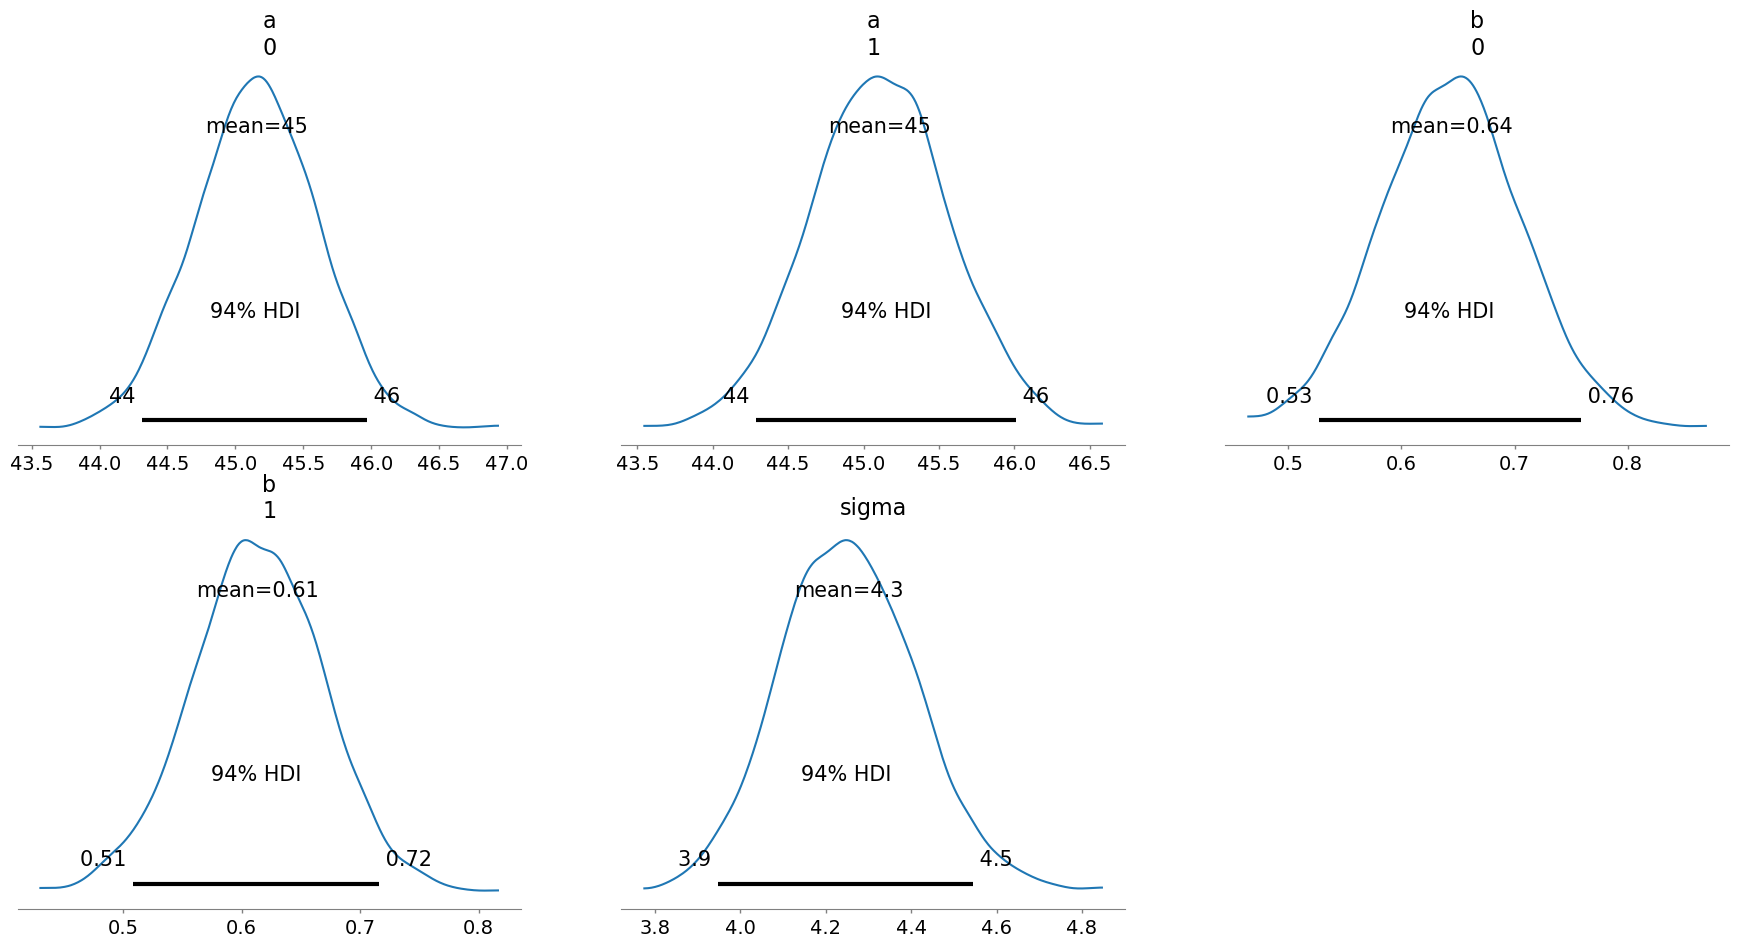

In [260]:
az.plot_posterior(dsex_trace)

In [274]:
x = np.linspace(data['height'].min(),data['height'].max(),100)
y0 = 45.153 + 0.644 * (x-np.mean(x))
y1 = 45.107 + 0.614 * (x-np.mean(x))

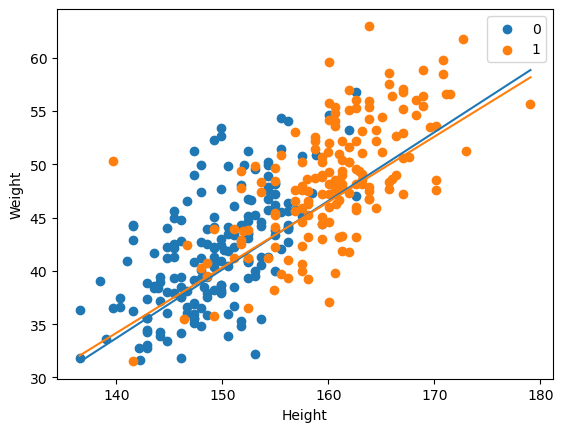

In [275]:
grouped = data.groupby('male')
for name,group in grouped:
    plt.scatter(group['height'],group['weight'],label=name)
plt.plot(x,y0)
plt.plot(x,y1)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.legend()

In [286]:
with dsex_model:
    dsex_trace.extend(pm.sample_posterior_predictive(dsex_trace, extend_inferencedata = True))
#az.plot_hdi(data['height'],dsex_trace.posterior['b'])

Sampling: [W]


<AxesSubplot: >

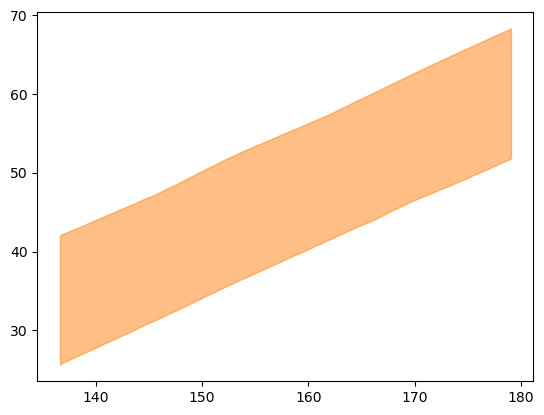

In [295]:
#az.plot_hdi(data['height'],dsex_trace.posterior_predictive)
az.plot_hdi(data['height'],dsex_trace.posterior_predictive['W'])

array([[<AxesSubplot: title={'center': 'a\n0'}>,
        <AxesSubplot: title={'center': 'a\n1'}>,
        <AxesSubplot: title={'center': 'b\n0'}>],
       [<AxesSubplot: title={'center': 'b\n1'}>,
        <AxesSubplot: title={'center': 'sigma'}>, <AxesSubplot: >]],
      dtype=object)

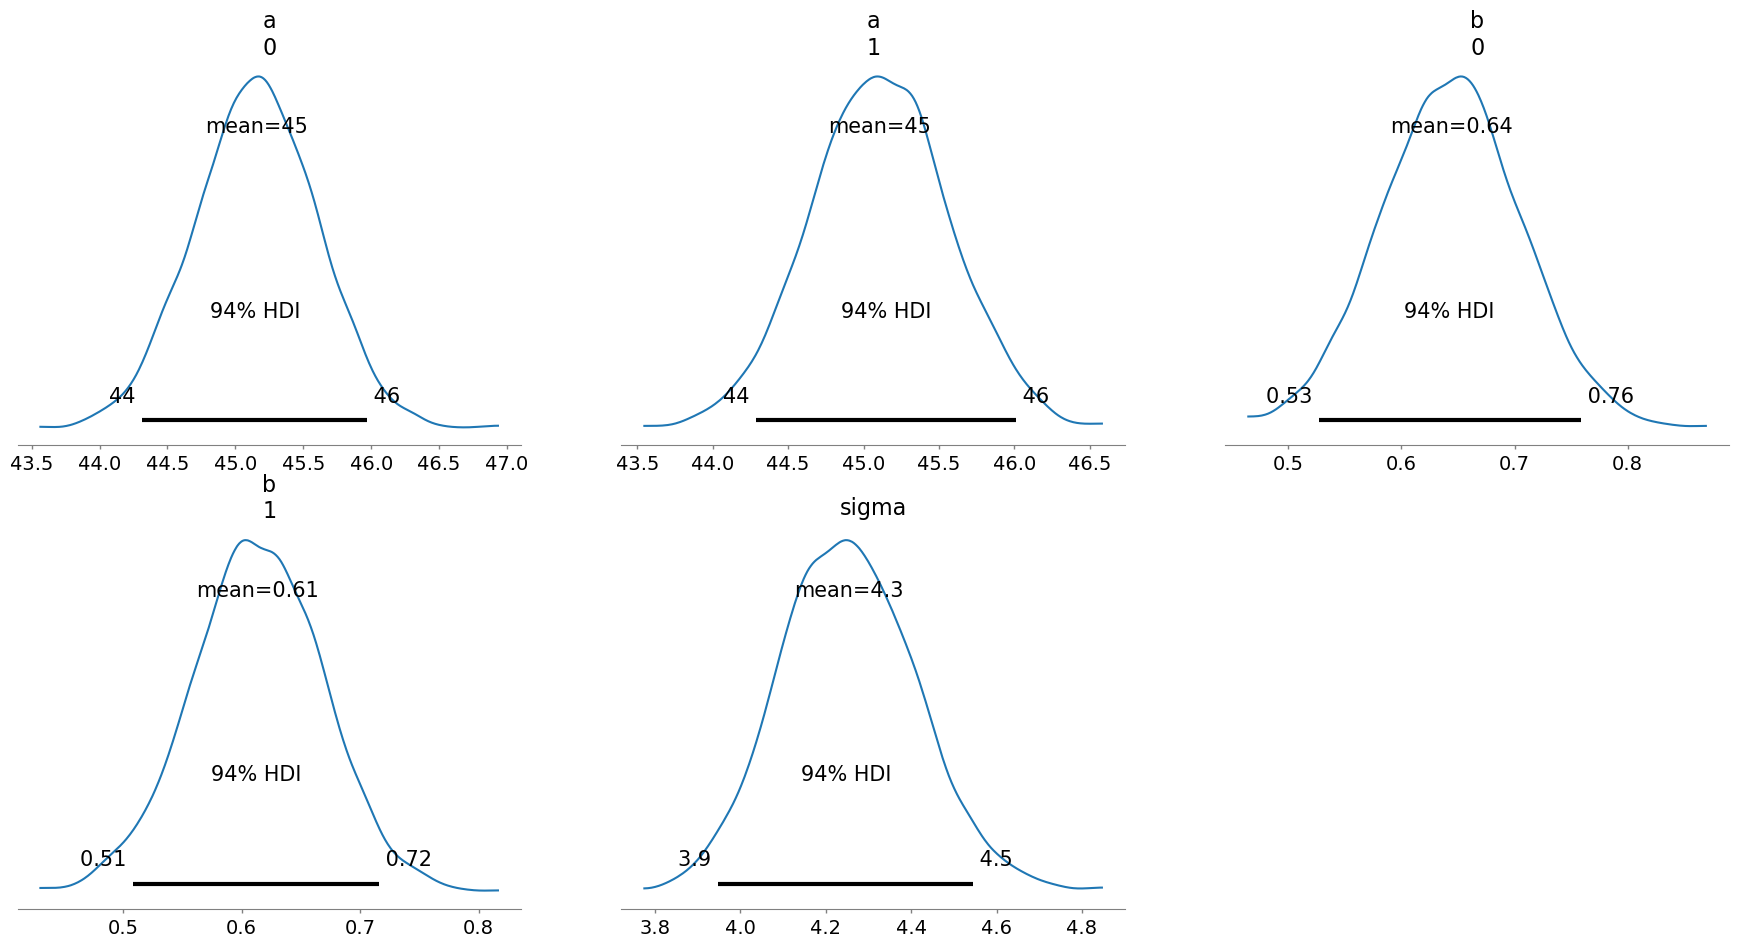

In [297]:
az.plot_posterior(dsex_trace)

In [324]:
az.summary(dsex_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],45.153,0.447,44.314,45.972,0.008,0.006,2857.0,2954.0,1.0
a[1],45.107,0.455,44.289,46.009,0.008,0.006,3144.0,2526.0,1.0
b[0],0.644,0.062,0.527,0.758,0.001,0.001,2763.0,2592.0,1.0
b[1],0.614,0.055,0.508,0.716,0.001,0.001,3411.0,2791.0,1.0
sigma,4.253,0.160,3.948,4.546,0.003,0.002,3463.0,3035.0,1.0


In [320]:
dsex_trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [330]:
with dsex_model:
    dsex_pp = pm.sample_posterior_predictive(dsex_trace, var_names = ['a', 'b','W'])

Sampling: [W, a, b]


In [334]:
dsex_pp.posterior_predictive

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, a_dim_2: 2, b_dim_2: 2, W_dim_2: 346)
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * a_dim_2  (a_dim_2) int32 0 1
  * b_dim_2  (b_dim_2) int32 0 1
  * W_dim_2  (W_dim_2) int32 0 1 2 3 4 5 6 7 ... 338 339 340 341 342 343 344 345
Data variables:
    a        (chain, draw, a_dim_2) float64 54.32 38.63 34.12 ... 47.69 48.02
    b        (chain, draw, b_dim_2) float64 1.148 0.8207 ... -1.041 -11.73
    W        (chain, draw, W_dim_2) float64 35.3 33.95 37.88 ... 51.56 3.414
Attributes:
    created_at:                 2023-01-13T08:28:45.061855
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.1

In [337]:
contrast_pp_a = dsex_pp.posterior_predictive['a'][1] - dsex_pp.posterior_predictive['a'][0]
contrast_pp_b = dsex_pp.posterior_predictive['b'][1] - dsex_pp.posterior_predictive['b'][0]
contrast_pp_w = dsex_pp.posterior_predictive['W'][1] - dsex_pp.posterior_predictive['W'][0]

In [366]:
#az.plot_density(contrast_pp_w)

array([[<AxesSubplot: title={'center': 'a\n0'}>,
        <AxesSubplot: title={'center': 'a\n1'}>,
        <AxesSubplot: title={'center': 'b\n0'}>],
       [<AxesSubplot: title={'center': 'b\n1'}>,
        <AxesSubplot: title={'center': 'sigma'}>, <AxesSubplot: >]],
      dtype=object)

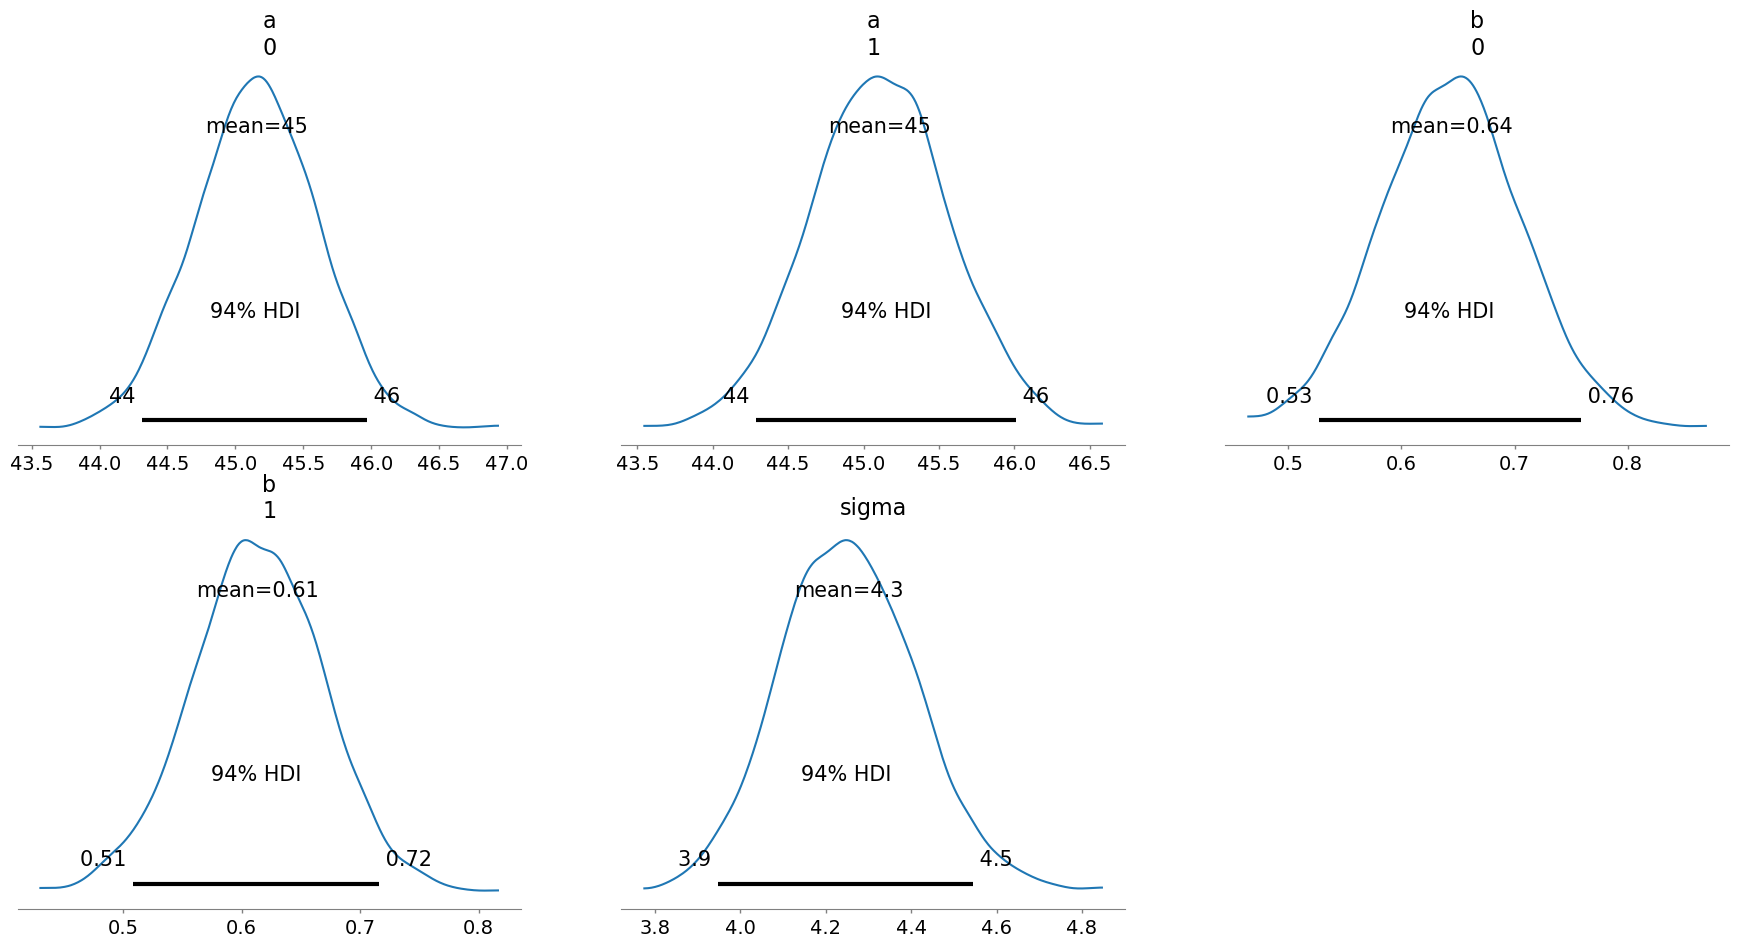

In [373]:
az.plot_posterior(dsex_trace)

In [355]:
#az.kde(dsex_pp.posterior_predictive['W'][0])=

## Full Luxury Bayes

Using one model, with all fo the submodels inside it. 


In [ ]:
with pm.Model() as full_model:
    #Height
    